<a href="https://colab.research.google.com/github/ocriado91/SpocMining/blob/5-data-exploration-notebook/notebooks/01_spoc_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SpOC - Mine the Belt Challenge. Data exploration

In the previous [notebook](https://github.com/ocriado91/SpocMining/blob/main/notebooks/00_intro_and_evalution_code.ipynb) we introduced SpoC Mine The Belt Challenge and executed the evaluation example code to obtain a score of `0.58`.

In this notebook, we are to deep understand the data into `candidates.txt`

## Installation from conda
To execute conda into the notebook we need to install `condacolab` package.

__NOTE__: We need to restart the kernel after package installation.

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


And now we can install the `pykep` package using `conda`:

In [2]:
!conda install pykep

Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | / - \ done


==> WARNING: A newer version of conda exists. <==
    current version: 23.11.0
    latest version: 24.4.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



# First approach of Data Exploration

Once the packages are installed, we can begin with the Data Exploration to extract the first insights of the challenge's data.

## Imports

First of all, we need to import the Python packages that we are going to use into this data exploration. At this moment, just we are going to use:

* `polars`: I'm a very fan of this package due to its performance and I use it into all my data projects.
* `pykep`: Th installed packaged into previous steps.
* `seaborn`: To generate plots.

In [3]:
import matplotlib.pyplot as plt
import polars as pl
import pykep as pk
import seaborn as sns


/usr/local/lib/python3.10/site-packages/pykep/util/gravity_spherical_harmonic.py:156: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _calculate_normalisation_parameters(n_max):


# Data Exploration
## Reading input data

First of all, we need to download the [dataset](https://api.optimize.esa.int/data/spoc/mining/candidates.txt)

In [4]:
!wget https://api.optimize.esa.int/data/spoc/mining/candidates.txt

--2024-05-07 06:39:07--  https://api.optimize.esa.int/data/spoc/mining/candidates.txt
Resolving api.optimize.esa.int (api.optimize.esa.int)... 195.169.140.114
Connecting to api.optimize.esa.int (api.optimize.esa.int)|195.169.140.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2250000 (2.1M) [text/plain]
Saving to: ‘candidates.txt’

candidates.txt      100%[===================>]   2.15M  3.16MB/s    in 0.7s    

2024-05-07 06:39:09 (3.16 MB/s) - ‘candidates.txt’ saved [2250000/2250000]



And now, we can read it with polars and store it as Dataframe, add the column headers because they are not in the input data file, and cast `ID` and `Material Type` columns as integers to manage easier later.

In [5]:
# Set custom headers
HEADER = ["ID",
          "Semi-major axis [m]",
          "Eccentricity",
          "Inclination [rad]",
          "Ascending Node [rad]",
          "Argument of Periapsis [rad]",
          "True Anomaly [rad]",
          "Mass [0 to 1]",
          "Material Type"]

# Read asteroid candidates file
data = pl.read_csv("candidates.txt",
                   separator=" ",
                   new_columns=HEADER)

# Cast columns
data = data.cast({"ID": pl.UInt16,
           "Material Type": pl.UInt8})

# Show head
data.head()

ID,Semi-major axis [m],Eccentricity,Inclination [rad],Ascending Node [rad],Argument of Periapsis [rad],True Anomaly [rad],Mass [0 to 1],Material Type
u16,f64,f64,f64,f64,f64,f64,f64,u8
1,3.0835e10,0.008338,0.079912,3.912543,5.042492,2.617431,0.65811,3
2,2.3826e10,0.006097,0.006188,4.83121,4.589027,2.075072,0.964783,1
3,3.0512e10,0.001916,0.072551,2.277854,3.250898,1.168246,0.451917,0
4,2.9867e10,0.000553,0.013222,3.530913,4.200775,3.918279,0.668809,2
5,3.3090e10,0.004041,0.103529,2.281561,5.481973,5.145668,0.403246,2


## Analysis

So, once all python packages are installed and the input data read, we can start with our data exploration given answers to a questions:



### Q1. How many asteroids are of each type are?

According to the challenge description, the materials are equally distributed, but this is correct?

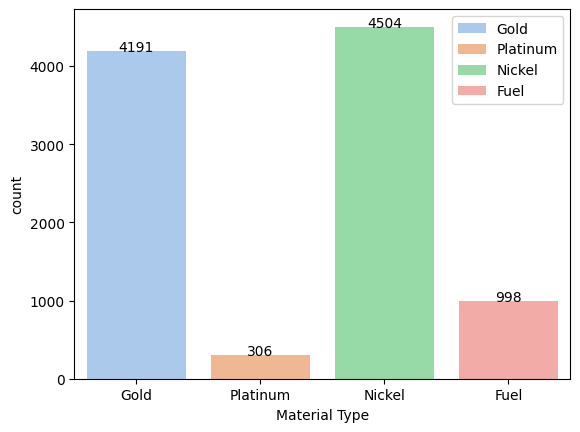

In [6]:
# Plot count
g = sns.countplot(data,
              x="Material Type",
              hue="Material Type",
              palette="pastel")

# Transform X-tick labels and legend label to material name
labels = ["Gold", "Platinum", "Nickel", "Fuel"]
g.set_xticks([0, 1, 2, 3])
g.set_xticklabels(labels)
g.legend(labels=labels)

# Extract the count of asteroids by material type
count_gold = data.filter(pl.col("Material Type") == 0).height
count_platinum = data.filter(pl.col("Material Type") == 1).height
count_nickel = data.filter(pl.col("Material Type") == 2).height
count_fuel = data.filter(pl.col("Material Type") == 3).height

# Add all counts into a list to write its values into countplot
counts = [count_gold, count_platinum, count_nickel, count_fuel]
for i in range(len(counts)):
  g.text(x=i,
         y=counts[i],
         s=str(counts[i]),
         horizontalalignment="center")


Ok, it is clear that ***we don't have a balanced distribution of asteroid by material type.***

### Q2. What is the maximum mass that the rover can mine?

According to challenge description, the final score is determined by the minimum of collected material of the tree types. So, we can obtain the theoretical maximum score according to asteroids data:

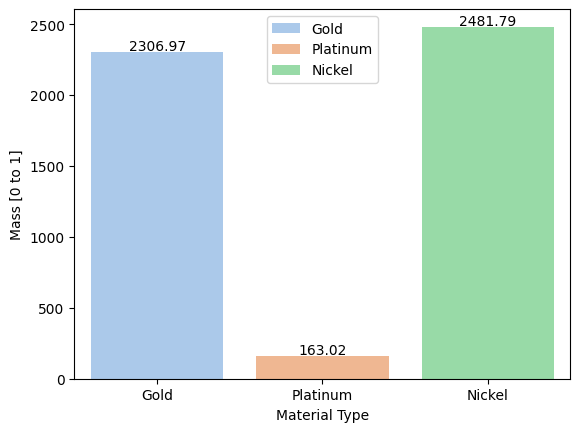

In [7]:
# Plot count
g = sns.barplot(data.filter(pl.col("Material Type") != 3),
                x="Material Type",
                y="Mass [0 to 1]",
                hue="Material Type",
                estimator="sum",
                errorbar=None,
                palette="pastel")

# Transform X-tick labels and legend label to material name
labels = ["Gold", "Platinum", "Nickel"]
g.set_xticks([0, 1, 2])
g.set_xticklabels(labels)
g.legend(labels=labels)

# Extract the count of asteroids by material type
mass_gold = data.filter(
    pl.col("Material Type") == 0
).sum()["Mass [0 to 1]"].item()

mass_platinum = data.filter(
    pl.col("Material Type") == 1
).sum()["Mass [0 to 1]"].item()
mass_nickel = data.filter(
    pl.col("Material Type") == 2
).sum()["Mass [0 to 1]"].item()

# Add all counts into a list to write its values into countplot
total_mass = [mass_gold, mass_platinum, mass_nickel]
for i in range(len(total_mass)):
  text = "{:.2f}".format(total_mass[i])
  g.text(x=i,
         y=int(total_mass[i]) + 10, # Put vertical position into the value + padding offset
         s=text,
         horizontalalignment="center")


Being the __theoretical maximum score__ equal to `163.02`

<Axes: xlabel='Material Type', ylabel='Mass [0 to 1]'>

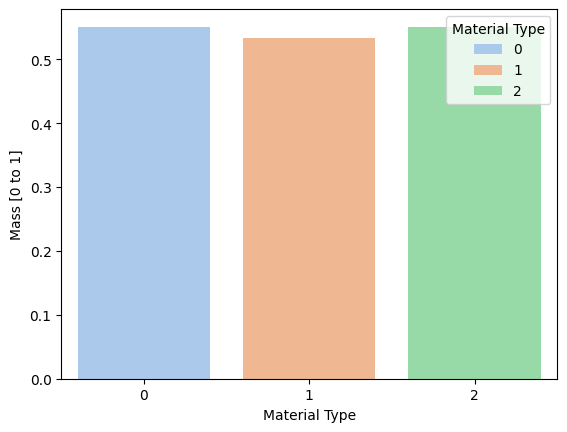

In [8]:
sns.barplot(data.filter(pl.col("Material Type") != 3),
                x="Material Type",
                y="Mass [0 to 1]",
                hue="Material Type",
                errorbar=None,
                palette="pastel")

<Axes: xlabel='Mass [0 to 1]', ylabel='Density'>

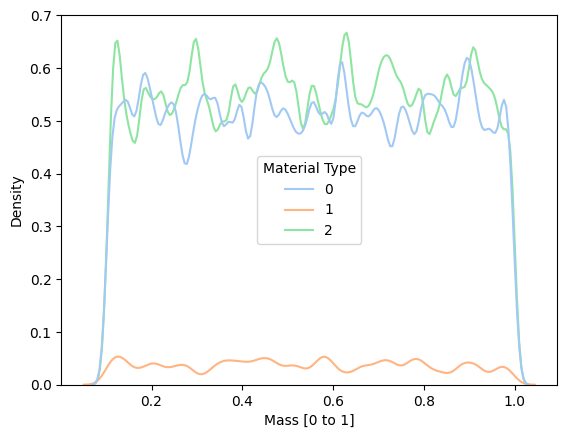

In [9]:
sns.kdeplot(data.filter(pl.col("Material Type") != 3),
            x="Mass [0 to 1]",
            hue="Material Type",
            palette="pastel",
            bw_adjust=0.2)

<Axes: xlabel='Mass [0 to 1]', ylabel='Proportion'>

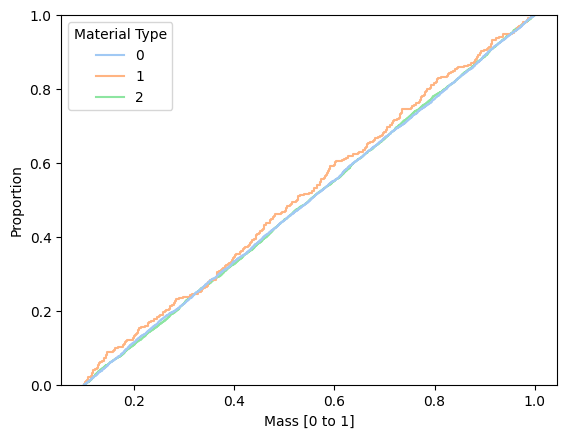

In [10]:
sns.ecdfplot(data.filter(pl.col("Material Type") != 3),
            x="Mass [0 to 1]",
            hue="Material Type",
            palette="pastel")